# Interacting with Jarvis via MDF Search
This notebook shows some examples for employing [matminer](https://github.com/hackingmaterials/matminer) to  to visualize data in [JARVIS](https://www.ctcms.nist.gov/~knc6/JVASP.html) and to screen that database for interesting materials. Uses the version of JARVIS available in the [Materials Data Facility](http://materialsdatafacility.org).

Last tested with matminer v0.4.5

In [1]:
%matplotlib inline

import itertools

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matminer.data_retrieval.retrieve_MDF import MDFDataRetrieval

## Get Jarvis Data
Connect to the MDF and download all the data from Jarvis, which is also available on [GitHub](https://github.com/usnistgov/jarvis/blob/master/jarvis/db/static/explore_db.py).

### Download the Data
We first create an instance of Matminer's MDFDataRetrieval, which simplifies performing search queries against the MDF.

In [2]:
mdf = MDFDataRetrieval(anonymous=True)

Get the version number of the current Jarvis dataset

In [3]:
query_string = 'mdf.source_name:jarvis AND mdf.resource_type:record'
data = mdf.get_data(query_string, unwind_arrays=False)
print('Found {} compounds'.format(len(data)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26559/26559 [00:38<00:00, 690.45it/s]


Found 26559 compounds


Each record contains a high-level description of the kind of data held in Jarvis, as well as the values for commonly used properties

In [4]:
data.head(2)

,crystal_structure.number_of_atoms,crystal_structure.space_group_number,crystal_structure.volume,dft.converged,dft.cutoff_energy,files,jarvis.band_gap.mbj,jarvis.band_gap.optb88vdw,jarvis.crossreference.materials_project,jarvis.dimensionality,...,material.composition,material.elements,mdf.ingest_date,mdf.mdf_id,mdf.parent_id,mdf.resource_type,mdf.scroll_id,mdf.source_id,mdf.source_name,mdf.version
0,16,193,181.081747,True,1200.0,"[{'data_type': 'ASCII text, with very long lin...",NaN,0.0068,mp-1111,3d,...,Mn5Si3,"[Mn, Si]",2018-11-13T16:44:17.471796Z,5beaffa52ef38879b395505a,5beaff612ef38879b3953c09,record,5201,jarvis_v1,jarvis,1
1,8,166,121.654162,True,850.0,"[{'data_type': 'ASCII text, with very long lin...",2.1427,2.0025,mp-12442,3d,...,KAuF6,"[Au, F, K]",2018-11-13T16:44:17.471796Z,5beaffa52ef38879b3955061,5beaff612ef38879b3953c09,record,5208,jarvis_v1,jarvis,1


In [5]:
data.columns

Index(['crystal_structure.number_of_atoms',
       'crystal_structure.space_group_number', 'crystal_structure.volume',
       'dft.converged', 'dft.cutoff_energy', 'files', 'jarvis.band_gap.mbj',
       'jarvis.band_gap.optb88vdw', 'jarvis.crossreference.materials_project',
       'jarvis.dimensionality', 'jarvis.elastic_moduli.bulk',
       'jarvis.elastic_moduli.shear', 'jarvis.formation_enthalpy', 'jarvis.id',
       'jarvis.landing_page', 'jarvis.total_energy', 'material.composition',
       'material.elements', 'mdf.ingest_date', 'mdf.mdf_id', 'mdf.parent_id',
       'mdf.resource_type', 'mdf.scroll_id', 'mdf.source_id',
       'mdf.source_name', 'mdf.version'],
      dtype='object')

## Make Some Simple Plots
Showcase what kind of data is available in JARVIS.

### How many compounds are 2D?
Just figure out how many compounds are from the 2D vs the 3D dataset

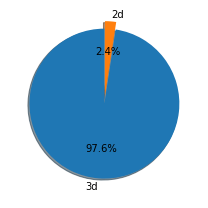

In [6]:
fig, ax = plt.subplots()

counts = data['jarvis.dimensionality'].value_counts()
ax.pie(counts, explode=[0, 0.1], labels=counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

fig.set_size_inches(3, 3)
fig.tight_layout()

### How are the spacegroups distributed?
How are the entries distributed throughout the 230 spacegroups?

(1, 231)

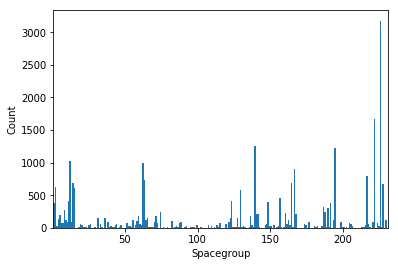

In [7]:
fig, ax = plt.subplots()

ax.hist(data['crystal_structure.space_group_number'], bins=range(1, 231));

ax.set_xlabel('Spacegroup')
ax.set_ylabel('Count')

ax.set_xlim(1, 231)

### Effect of Functionals on Predicted Properties
Jarvis uses two different eXchange-Correlation (XC) functionals for computing band gap energies with DFT: optB88-vdw, and MBJ. These plots show how well they compare

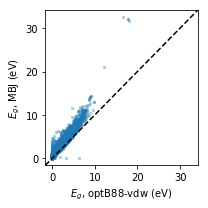

In [8]:
fig, ax = plt.subplots()

# Plot the two values
ax.scatter(data['jarvis.band_gap.optb88vdw'], 
           data['jarvis.band_gap.mbj'], alpha=0.3, s=5)

# Plot the equality line
ax.set_xlim(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]))
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('$E_g$, optB88-vdw (eV)')
ax.set_ylabel('$E_g$, MBJ (eV)')

fig.set_size_inches(3, 3)
fig.tight_layout()

### How related are different elastic moduli?
Are shear and bulk moduli generally correlated?

Text(0,0.5,'Shear Modulus (GPa)')

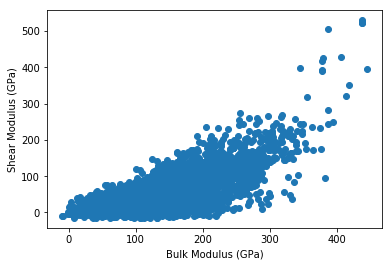

In [9]:
fig, ax = plt.subplots()

subset = data[data['jarvis.dimensionality'] == "3d"]

ax.scatter(subset['jarvis.elastic_moduli.bulk'],
                  subset['jarvis.elastic_moduli.shear'])

ax.set_xlabel('Bulk Modulus (GPa)')
ax.set_ylabel('Shear Modulus (GPa)')

Same plot, minus the compounds with negative moduli

Text(0,0.5,'Shear Modulus (GPa)')

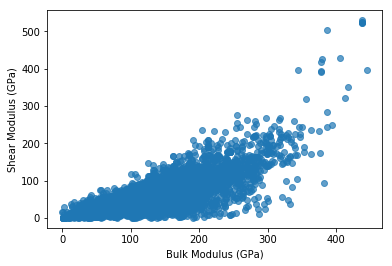

In [10]:
fig, ax = plt.subplots()

subset = subset[np.logical_and(subset['jarvis.elastic_moduli.bulk'] > 0,
                subset['jarvis.elastic_moduli.shear'] > 0)]

ax.scatter(subset['jarvis.elastic_moduli.bulk'], subset['jarvis.elastic_moduli.shear'],
          alpha=0.7)

ax.set_xlabel('Bulk Modulus (GPa)')
ax.set_ylabel('Shear Modulus (GPa)')

## Some Example Screening
Just do demonstrate some screening that you can do with the [Forge client](https://github.com/materials-data-facility/forge), which can access via the MDFDataRetrieval object to get access to the raw data

In [11]:
screened_results = mdf.forge.aggregate('mdf.source_name:jarvis AND jarvis.band_gap.mbj:[1.1 TO 1.6] '
                                       'AND jarvis.dimensionality:2d')

Each record is a dictionary

In [12]:
screened_results[0]

{'crystal_structure': {'number_of_atoms': 8,
  'space_group_number': 11,
  'volume': 747.0360494448431},
 'dft': {'converged': True, 'cutoff_energy': 500.0},
 'files': [{'data_type': 'ASCII text, with very long lines, with no line terminators',
   'filename': 'JVASP-27859.json',
   'globus': 'globus://e38ee745-6d04-11e5-ba46-22000b92c6ec/MDF/mdf_connect/prod/data/jarvis_v1/jdft_2d-7-7-2018.json/JVASP-27859.json',
   'length': 6117,
   'mime_type': 'text/plain',
   'sha512': '6d3a61ae784a9374794fda998a9cd485c8b6dfd690508b44f93e7cf1ff5f208d799e958af6e01a07d9058668bc2a01c1bc6a1664acce9b5f385f36d6883d1810',
   'url': 'https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e.globus.org/MDF/mdf_connect/prod/data/jarvis_v1/jdft_2d-7-7-2018.json/JVASP-27859.json'}],
 'jarvis': {'band_gap': {'mbj': 1.4936, 'optb88vdw': 0.6651},
  'crossreference': {'materials_project': 'mp-1025522'},
  'dimensionality': '2d',
  'formation_enthalpy': -0.923,
  'id': 'JVASP-27859',
  'landing_page': 'https://www.ctcms.nist

Print out some materials with band gap energies in the range desired for solar cells

In [13]:
print('Found {} materials with band gaps between 1.1 and 1.6 eV:'.format(len(screened_results)))
for result in screened_results:
    print('Composition: %s - Gap: %.2f eV - URL: %s'%(result['material']['composition'],
                                                      result['jarvis']['band_gap'].get('mbj', np.nan),
                                                      result['jarvis']['landing_page']))

Found 8 materials with band gaps between 1.1 and 1.6 eV:
Composition: ThTe3 - Gap: 1.49 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-27859.html
Composition: GaGeTe - Gap: 1.42 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-60595.html
Composition: Bi2Te4Pb - Gap: 1.27 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-28130.html
Composition: CuBi(PSe3)2 - Gap: 1.24 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-60464.html
Composition: PdI2 - Gap: 1.26 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-60293.html
Composition: Nb(SeBr)2 - Gap: 1.22 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-14420.html
Composition: Nb(SeBr)2 - Gap: 1.20 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-60390.html
Composition: Bi2PbSe4 - Gap: 1.14 eV - URL: https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-28127.html
